## Imports and functions

In [1]:
import Levenshtein
from tqdm import tqdm
from sklearn.metrics import (roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay)
import torch
torch.cuda.empty_cache()

from py_scipts.utils import *

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import plotly.io as pio
pio.kaleido.scope.mathjax = None

import tkinter as tk
from tkinter import filedialog

root = tk.Tk()
root.withdraw()


''

#### Utils functions

In [2]:
model_path = input("Model path (continue for default : hubaval/llama-3.1-8B-syslogs)") or 'hubaval/llama-3.1-8B-syslogs' #Default hubaval/llama-3.1-8B-fttlogs
#dataset_path = input("Dataset path (continue for default : ../data/eval/EVAL-STB)") or '../data/eval/EVAL-STB' # Default ../data/eval/EVAL-STB
dataset_path = filedialog.askdirectory(initialdir="../data", parent=root, title="Choose folder (Default : ../data/eval/EVAL-STB)") or '../data/eval/EVAL-STB'
selected_metrics = input("Metrics (continue for default : jaccard,levenshtein,exact,similarity)") or 'jaccard,levenshtein,exact,similarity'
DATASETS = input("Datasets to show (continue for default) : ''") or ''

selected_metrics = [metric.strip() for metric in selected_metrics.split(',')]

if DATASETS == '':
    DATASETS = []
elif ',' not in DATASETS:
    DATASETS = [DATASETS.strip()]
else:
    DATASETS = [dataset.strip() for dataset in DATASETS.split(',')]

print(f"""
Selected parameters
- {model_path}
- {dataset_path}
- {selected_metrics}
- {DATASETS}""")


Selected parameters
- hubaval/llama-3.1-8B-syslogs
- D:/Projets/Recherche/LogAD-LLM/data/eval/EVALCROSSED-STBSTAMP2
- ['jaccard', 'levenshtein', 'exact', 'similarity']
- []


In [3]:
def show_anomalies_count(df, columns=selected_metrics, range=None):
    fig = make_subplots(rows=2, cols=3, subplot_titles=columns)
    figs = make_subplots()

    for idx, label in enumerate(columns):
        df_petit = df[[label, 'Label']].copy()
        df_petit = df_petit[df_petit[label].notna()]

        if range:
            df_petit_norm = df_petit[df_petit['Label'] == 0][label]
            counts_norm = df_petit_norm.value_counts().sort_index()
            cumulative_counts_norm = counts_norm.cumsum()

            df_petit_ano = df_petit[df_petit['Label'] == 1][label]
            counts_ano = df_petit_ano.value_counts().sort_index()
            cumulative_counts_ano = counts_ano.cumsum()


            fig.add_trace(go.Scatter(
                x=cumulative_counts_norm.index,  # x-axis is the similarity values (scores)
                y=cumulative_counts_norm.values,  # y-axis is the count of each similarity value
                mode='lines+markers',  # Line plot with markers at each data point
                name=label + " NORM",
                line=dict(color='cyan', width=2),
            ),row=(idx // 3) + 1, col=(idx % 3) + 1)

            fig.add_trace(go.Histogram(
                x=df_petit_ano,  # Values from the current label
                nbinsx=500,  # Number of bins for the histogram
                name=f'Distribution {label}',
                opacity=0.6  # Adjust the transparency for better visibility if overlaying
            ), row=(idx // 3) + 1, col=(idx % 3) + 1)

            fig.add_trace(go.Scatter(
                x=cumulative_counts_ano.index,  # x-axis is the similarity values (scores)
                y=cumulative_counts_ano.values,  # y-axis is the count of each similarity value
                mode='lines+markers',  # Line plot with markers at each data point
                name=label + " ANO",
                line=dict(color='red', width=2),
            ),row=(idx // 3) + 1, col=(idx % 3) + 1)


            threshold = df_petit_norm.quantile(0.05)
            fig.add_trace(go.Scatter(
                x=[threshold, threshold],
                y=[0, df_petit_norm.shape[0]],
                mode="lines",
                line=dict(color="cyan", width=2, dash="dash"),
                name=f'Threshold NORM {label} ({threshold})'
            ),row=(idx // 3) + 1, col=(idx % 3) + 1)

            threshold = df_petit_ano.quantile(0.95)
            fig.add_trace(go.Scatter(
                x=[threshold, threshold],
                y=[0, df_petit_ano.shape[0]],
                mode="lines",
                line=dict(color="red", width=2, dash="dash"),
                name=f'Threshold ANO {label} ({threshold})'
            ),row=(idx // 3) + 1, col=(idx % 3) + 1)

            if label == "similarity":
                figs.add_trace(go.Scatter(
                    x=cumulative_counts_norm.index,  # x-axis is the similarity values (scores)
                    y=cumulative_counts_norm.values,  # y-axis is the count of each similarity value
                    mode='lines+markers',  # Line plot with markers at each data point
                    name="Normal Logs",
                    line=dict(color='cyan', width=2),
                ))
                figs.add_trace(go.Scatter(
                    x=[0.880371, 0.880371],
                    y=[0, df_petit_ano.shape[0]],
                    mode="lines",
                    line=dict(color="black", width=2, dash="dash"),
                    name=f'Optimal Threshold ({0.88})'
                ))


                figs.add_trace(go.Scatter(
                    x=cumulative_counts_ano.index,  # x-axis is the similarity values (scores)
                    y=cumulative_counts_ano.values,  # y-axis is the count of each similarity value
                    mode='lines+markers',  # Line plot with markers at each data point
                    name= "Anomaly Logs",
                    line=dict(color='red', width=2),

                ))

                figs.update_layout(
                    xaxis_title="Similarity Score",
                    yaxis_title="Number of anomalies detected",
                    paper_bgcolor='rgba(0,0,0,0)',
                    plot_bgcolor='rgba(0,0,0,0)',
                    width=500,
                    margin=dict(l=20, r=20, t=20, b=20),
                    legend=dict(
                        orientation="h",
                        yanchor="bottom",
                        y=1.02,
                        xanchor="center",
                        x=0.5,
                        traceorder="reversed"
                        ),
                        font=dict(
                            family="Times New Roman",
                            size=20,
                            color="black"
                        )
                    )
                figs.show()
                figs.write_image("../out/SIMILARITY.pdf", format="pdf")

        else:
            counts = df_petit[label].value_counts().sort_index()
            cumulative_counts = counts.cumsum()
            fig.add_trace(go.Scatter(
                x=cumulative_counts.index,  # x-axis is the similarity values (scores)
                y=cumulative_counts.values,  # y-axis is the count of each similarity value
                mode='lines+markers',  # Line plot with markers at each data point
                name=label,
                line=dict(color='cyan', width=2),
            ),row=(idx // 3) + 1, col=(idx % 3) + 1)

            fig.add_trace(go.Histogram(
                x=df_petit[label],  # Values from the current label
                nbinsx=30,  # Number of bins for the histogram
                name=f'Distribution {label}',
                opacity=0.6  # Adjust the transparency for better visibility if overlaying
            ), row=(idx // 3) + 1, col=(idx % 3) + 1)

            threshold = df_petit[label].quantile(0.5)
            fig.add_trace(go.Scatter(
                x=[threshold, threshold],
                y=[0, df_petit[label].shape[0]],
                mode="lines",
                line=dict(color="red", width=2, dash="dash"),
                name=f'Threshold {label} ({threshold})'
            ),row=(idx // 3) + 1, col=(idx % 3) + 1)

    # Update layout
    fig.update_layout(
        title=f"Evolution of Anomalies Detection ({range})",

        title_x=0.5,
        template='plotly_dark',
        legend=dict(
            orientation='h',  # Horizontal legend
            y=-0.2,  # Moves the legend below the plot (negative value moves it lower)
            x=0.5,  # Centers the legend horizontally
            xanchor='center',  # Anchors the legend in the center horizontally
            yanchor='top'  # Anchors the legend to the top of the legend box
        ),
        height=800,
    )

    fig.show()

def jaccard_idx(log1, log2):
    set1 = set(log1.split())
    set2 = set(log2.split())

    intersection = set1.intersection(set2)
    union = set1.union(set2)

    return len(intersection) / len(union)

def exact_mtc(l1, l2):
    tok1 = tokenizer(l1)
    tok2 = tokenizer(l2)

    same = [1 if token in tok2['input_ids'] else 0 for token in tok1['input_ids']]
    return sum(same)/len(tok1['input_ids'])

def levenshtein_dist(a, b):
    lev_distance = Levenshtein.distance(a, b)
    max_len = max(len(a), len(b))
    normalized_distance = lev_distance / max_len

    similarity = 1 - normalized_distance
    return similarity

def generate_flags(row, sim_func, thresh):
    if type(thresh) == list:
        sim_thresh = []
        for tr in thresh:
            if row[sim_func] == row[sim_func] and row[sim_func] >= tr:
                sim_thresh.append(0)
            else:
                sim_thresh.append(1)
        return str(sim_thresh)
    else:
        if row[sim_func] == row[sim_func] and row[sim_func] >= thresh:
            return 0
        else:
            return 1

def simi_process(df, cut=False):
    if cut:
        df[['target_text', 'targ_tmstp']] = df.progress_apply(lambda row: pd.Series(cut_timestamp(row['full_target_text'])), axis=1)
        df[["predicted", "pred_tmstp"]] = df.progress_apply(lambda row: pd.Series(cut_timestamp(row['full_predicted'])), axis=1)

    df['jaccard'] = df.progress_apply(lambda row: jaccard_idx(row['target_text' if cut else 'full_target_text'], row['predicted' if cut else 'full_predicted']), axis=1)
    print("Jaccard Index Done")
    df['levenshtein'] = df.progress_apply(lambda row: levenshtein_dist(row['target_text' if cut else 'full_target_text'], row['predicted' if cut else 'full_predicted']), axis=1)
    print("Levenshtein Distance Done")
    df['exact'] = df.progress_apply(lambda row: exact_mtc(row['target_text' if cut else 'full_target_text'], row['predicted' if cut else 'full_predicted']), axis=1)
    print("Exact Match Done")

    return df

def what_metrics(dataset="all", global_threshold=None):
    df_metrics = df.copy()
    simi_threshold=None

    if dataset != "all":
        try:
            if isinstance(dataset, list):
                df_metrics = df_metrics[df_metrics['source'].isin(dataset)]
            else:
                df_metrics = df_metrics[df_metrics['source'] == dataset]

            if df_metrics.shape[0] == 0:
                raise ValueError(f"Invalid dataset: {dataset}")
        except ValueError as e:
            print(e)
            df_metrics = df.copy()

    current_ds = df_metrics['source'].unique()
    print(f"Metrics for {', '.join(current_ds)} datasets, on {dataset_path}")
    y_test = df_metrics['Label'].tolist()

    fig = make_subplots(rows=2, cols=3)

    figsave, axsave = plt.subplots()

    fig2, axs2 = plt.subplots(2, 2, figsize=(16, 8))
    fig8, axs8 = plt.subplots(2, 2, figsize=(16, 8))


    axs2 = axs2[0].tolist() + axs2[1].tolist()
    axs8 = axs8[0].tolist() + axs8[1].tolist()
    axs8 = iter(axs8)
    axs2 = iter(axs2)
    results =[]

    for label in selected_metrics:
        values = df_metrics[label].tolist()
        threshold_used=None


        #Pos_lable = 0 car, si values considéré comme probabilités alors on veux 100% - 1.0 de score similarité pour le label positif 0
        # en gros, si probabilité proche de 1 (similarité) on veut représenter ça comme un log normal (0), et si proba proche de 0, alors plus de chance d'être une anomalie
        fpr, tpr, thresholds = roc_curve(y_test, values, pos_label=0)

        distances = np.sqrt(fpr**2 + (1 - tpr)**2)
        optimal_idx = np.argmin(distances)
        optimal_threshold = thresholds[optimal_idx]

        if global_threshold is None or label!="similarity":
            threshold_used = optimal_threshold
        else:
            threshold_used = global_threshold

        df_metrics[f'{label}_isano'] = df_metrics.apply(generate_flags, axis=1, sim_func=label, thresh=threshold_used)
        y_pred = df_metrics[f'{label}_isano'].tolist()


        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()

        precision = tp / (tp + fp) if (tp + fp) != 0 else 0

        recall = tp / (tp + fn) if (tp + fn) != 0 else 0

        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

        cm_display = ConfusionMatrixDisplay(cm)
        cm_display.plot(ax=next(axs2), cmap='Blues')

        roc_display = RocCurveDisplay.from_predictions(y_test, values, ax=next(axs8), pos_label=0, plot_chance_level=True)
        roc_display.ax_.set_xlabel('False Positive Rate')
        roc_display.ax_.set_ylabel('True Positive Rate')
        roc_display.ax_.set_title(f'{label} ROC Curve')
        auc = roc_display.roc_auc

        results.append({
            'Label': label,
            'F1score': f1,
            'AUC': auc,
            'Recall': recall,
            'Precision': precision,
            'Specificity': specificity,
            'Threshold': threshold_used,
            'Optimal Threshold': optimal_threshold
        })

        if label == "similarity":
            roc_display = RocCurveDisplay.from_predictions(y_test, values, ax=axsave, pos_label=0, plot_chance_level=True)
            roc_display.ax_.set_xlabel('False Positive Rate', fontsize=14)
            roc_display.ax_.set_ylabel('True Positive Rate', fontsize=14)
            roc_display.ax_.tick_params(axis='both', which='major', labelsize=14)
            roc_display.ax_.legend(fontsize=14, loc='lower right')

            figsave.savefig(f"../out/{current_ds}-{dataset}.pdf", transparent=True, bbox_inches='tight')
            simi_threshold = threshold_used

    # df_metrics['isanoone__jacq'] = df_metrics.apply(testano, axis=1, simfunc='jacq', thresh=0.20)
    # df_metrics['isanoone__lev'] = df_metrics.apply(testano, axis=1, simfunc='lev', thresh=0.37)
    # df_metrics['isanoone__ttok'] = df_metrics.apply(testano, axis=1, simfunc='ttok', thresh=0.666)
    # df_metrics['isanoone__similarity'] = df_metrics.apply(testano, axis=1, simfunc='similarity', thresh=0.78)

    dt_results = pd.DataFrame(results)
    dt_results = dt_results.style.highlight_max(subset = dt_results.columns[1:], axis=0, props='color:white; font-weight:bold; background-color:darkblue;')
    display(dt_results)
    plt.show()

    return simi_threshold

## Load data

In [4]:
df = load_data(dataset_path, correct_to_float='similarity' if 'similarity' in selected_metrics else None)

## Sample

In [5]:
display(df.head(5))

input_text  \
0  1122143983 2005.07.23 R27-M1-NB-C:J14-U01 2005...   
1  1106611406 2005.01.24 sn445 Jan 24 16:03:26 sn...   
2  1108974585 2005.02.21 sadmin1 Feb 21 00:29:45 ...   
3  1131749832 2005.11.11 en124 Nov 11 14:57:12 en...   
4  1131749693 2005.11.11 tbird-sm1 Nov 11 14:54:5...   

                                         target_text       source  distance  \
0               RAS KERNEL INFO generating core.6411          BGL         1   
1  sadmin1/sadmin1 kernel: hda: drive not ready f...       SPIRIT         3   
2  sadmin1/sadmin1 dhcpd: DHCPDISCOVER from 00:11...       SPIRIT         1   
3  dn978/dn978 sshd[7007]: Accepted publickey for...  THUNDERBIRD         1   
4  dn335/dn335 sshd(pam_unix)[6908]: session open...  THUNDERBIRD         1   

                                        previous_log  target_indice  Label  \
0  1122143984 2005.07.23 R27-M1-NB-C:J08-U01 2005...        2548705      0   
1  1106611418 2005.01.24 sadmin1 Jan 24 16:03:38 ...        2225420      1   
2  1108974593 2005.02.21 sadmin1 Feb 21 00:29:53 ...        5348384      0   
3  1131749834 2005.11.11 dn978 Nov 11 14:57:14 dn...        1827959      0   
4  1131749694 2005.11.11 dn335 Nov 11 14:54:54 dn...        1827364      0   

                                      full_predicted  \
0  1122143984 2005.07.23 R27-M1-NB-C:J06-U01 2005...   
1  1106611417 2005.01.24 sn439 Jan 24 16:03:37 sn...   
2  1108974594 2005.02.21 sadmin1 Feb 21 00:29:54 ...   
3  1131749834 2005.11.11 dn978 Nov 11 14:57:14 dn...   
4  1131749694 2005.11.11 dn335 Nov 11 14:54:54 dn...   

                                    full_target_text  \
0  1122143984 2005.07.23 R27-M1-NB-C:J04-U01 2005...   
1  1106611419 2005.01.24 sadmin1 Jan 24 16:03:39 ...   
2  1108974594 2005.02.21 sadmin1 Feb 21 00:29:54 ...   
3  1131749834 2005.11.11 dn978 Nov 11 14:57:14 dn...   
4  1131749694 2005.11.11 dn335 Nov 11 14:54:54 dn...   

                                          targ_tmstp  \
0  1122143984 2005.07.23 R27-M1-NB-C:J04-U01 2005...   
1      1106611419 2005.01.24 sadmin1 Jan 24 16:03:39   
2      1108974594 2005.02.21 sadmin1 Feb 21 00:29:54   
3        1131749834 2005.11.11 dn978 Nov 11 14:57:14   
4        1131749694 2005.11.11 dn335 Nov 11 14:54:54   

                                           predicted  \
0               RAS KERNEL INFO generating core.6411   
1  sn439/sn439 pbs_mom: tm_eof, matching task loc...   
2  sadmin1/sadmin1 dhcpd: DHCPDISCOVER from 00:11...   
3  dn978/dn978 sshd[7013]: Accepted publickey for...   
4  dn335/dn335 sshd[6905]: Accepted publickey for...   

                                          pred_tmstp  similarity  
0  1122143984 2005.07.23 R27-M1-NB-C:J06-U01 2005...    0.999512  
1        1106611417 2005.01.24 sn439 Jan 24 16:03:37    0.640625  
2      1108974594 2005.02.21 sadmin1 Feb 21 00:29:54    0.940430  
3        1131749834 2005.11.11 dn978 Nov 11 14:57:14    0.991211  
4        1131749694 2005.11.11 dn335 Nov 11 14:54:54    0.847168

## Load tokenizer & compute similarity scores

In [6]:
CModel = CustomModel(model_path)
tokenizer = CModel.load_tokenizer()

tqdm.pandas()
df = simi_process(df, cut=False)
df.sample(2)

CustomModel start ---- hubaval/llama-3.1-8B-syslogs
CustomModel setup ---- Working on device : 0
CustomModel setup ---- Selected environment : EnumEnv.DEVELOPMENT
CustomModel tokenizer ---- Loading tokenizer
CustomModel tokenizer ---- Done


100%|██████████| 6000/6000 [00:00<00:00, 79981.90it/s]


Jaccard Index Done


100%|██████████| 6000/6000 [00:00<00:00, 86936.09it/s]


Levenshtein Distance Done


100%|██████████| 6000/6000 [00:02<00:00, 2892.94it/s]

Exact Match Done


input_text  \
3896  1108976673 2005.02.21 sadmin1 Feb 21 01:04:33 ...   
2046  1105367707 2005.01.10 sadmin1 Jan 10 06:35:07 ...   

                                            target_text  source  distance  \
3896  sadmin1/sadmin1 dhcpd: DHCPDISCOVER from 00:11...  SPIRIT         1   
2046  sadmin1/sadmin1 kernel: hda: status error: sta...  SPIRIT         3   

                                           previous_log  target_indice  Label  \
3896  1108976686 2005.02.21 sadmin1 Feb 21 01:04:46 ...        5352220      0   
2046  1105367808 2005.01.10 sadmin1 Jan 10 06:36:48 ...         759434      1   

                                         full_predicted  \
3896  1108976690 2005.02.21 sadmin1 Feb 21 01:04:50 ...   
2046  1105367810 2005.01.10 sn249 Jan 10 06:36:50 sn...   

                                       full_target_text  \
3896  1108976686 2005.02.21 sadmin1 Feb 21 01:04:46 ...   
2046  1105367808 2005.01.10 sadmin1 Jan 10 06:36:48 ...   

                                         targ_tmstp  \
3896  1108976686 2005.02.21 sadmin1 Feb 21 01:04:46   
2046  1105367808 2005.01.10 sadmin1 Jan 10 06:36:48   

                                              predicted  \
3896  sadmin1/sadmin1 dhcpd: DHCPDISCOVER from 00:11...   
2046  sn249/sn249 sendmail[11438]: j0ED3k6I011438: f...   

                                         pred_tmstp  similarity   jaccard  \
3896  1108976690 2005.02.21 sadmin1 Feb 21 01:04:50    0.971680  0.714286   
2046    1105367810 2005.01.10 sn249 Jan 10 06:36:50    0.530273  0.115385   

      levenshtein     exact  
3896     0.933333  0.913043  
2046     0.298429  0.577778

## Show Anomaly Scores & Count

In [7]:
show_anomalies_count(df, columns=selected_metrics, range=True)
show_anomalies_count(df,columns=selected_metrics)

## Show metrics tables & AUROC + Confusion Matrix Plots

Metrics for BGL, SPIRIT, THUNDERBIRD datasets, on D:/Projets/Recherche/LogAD-LLM/data/eval/EVALCROSSED-STBSTAMP2


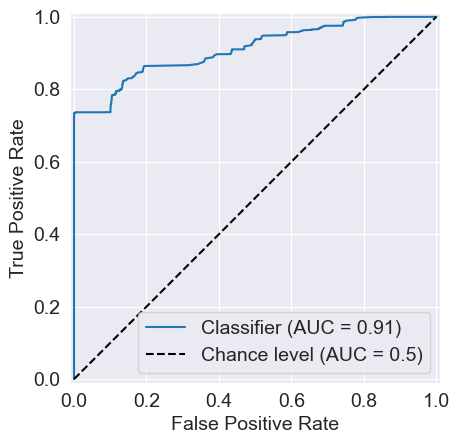

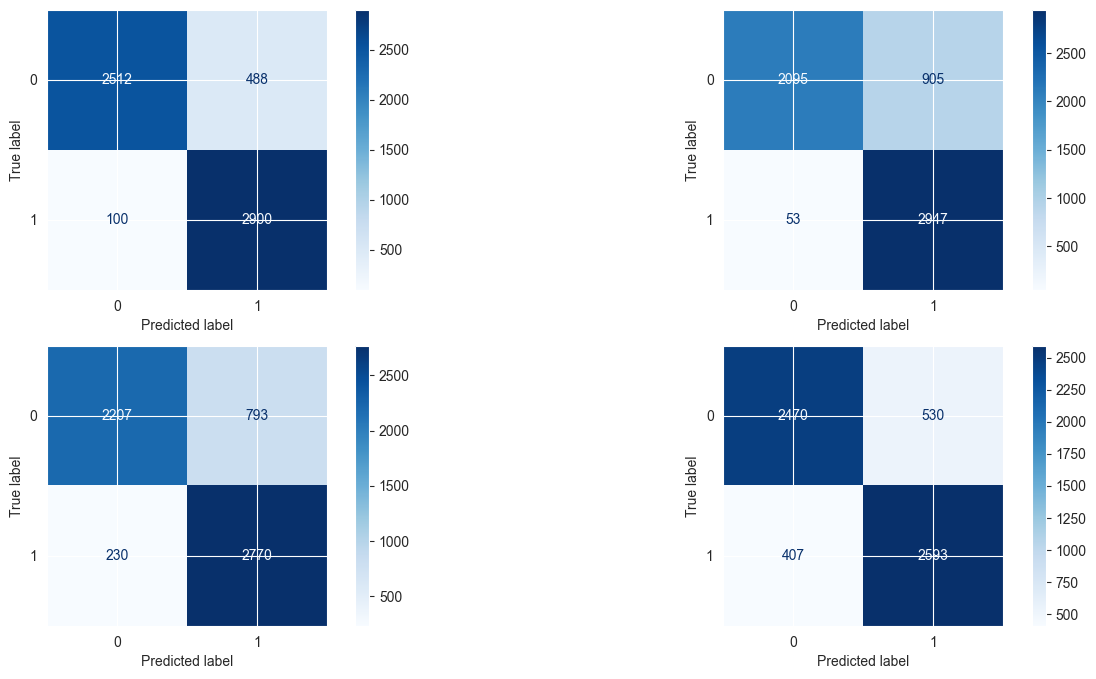

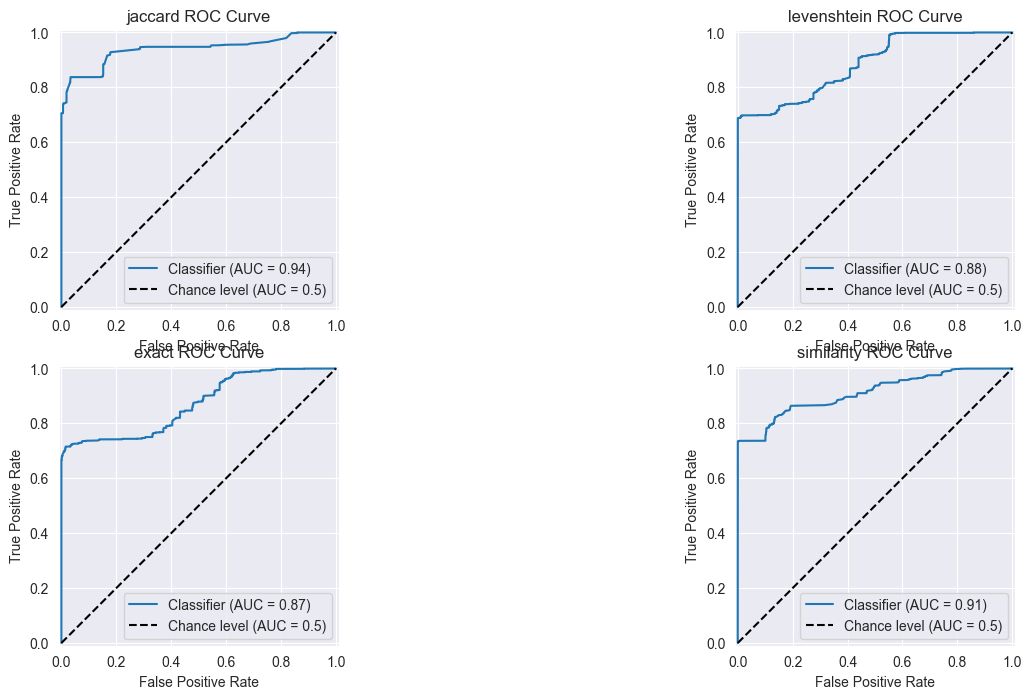

Metrics for BGL datasets, on D:/Projets/Recherche/LogAD-LLM/data/eval/EVALCROSSED-STBSTAMP2


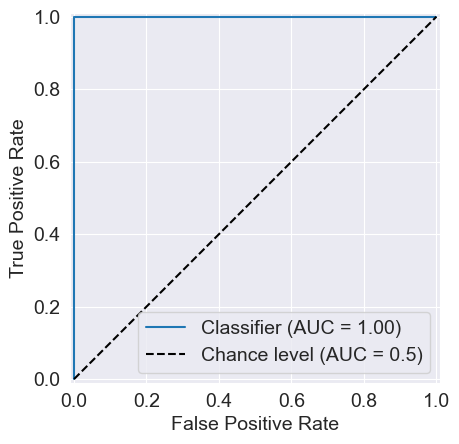

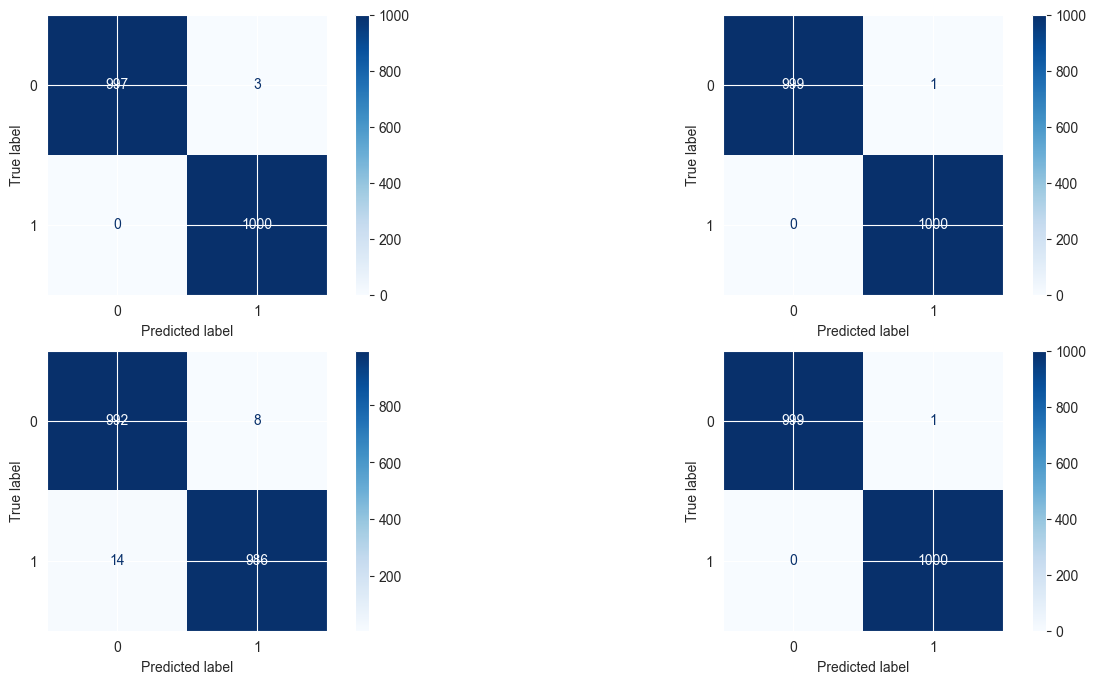

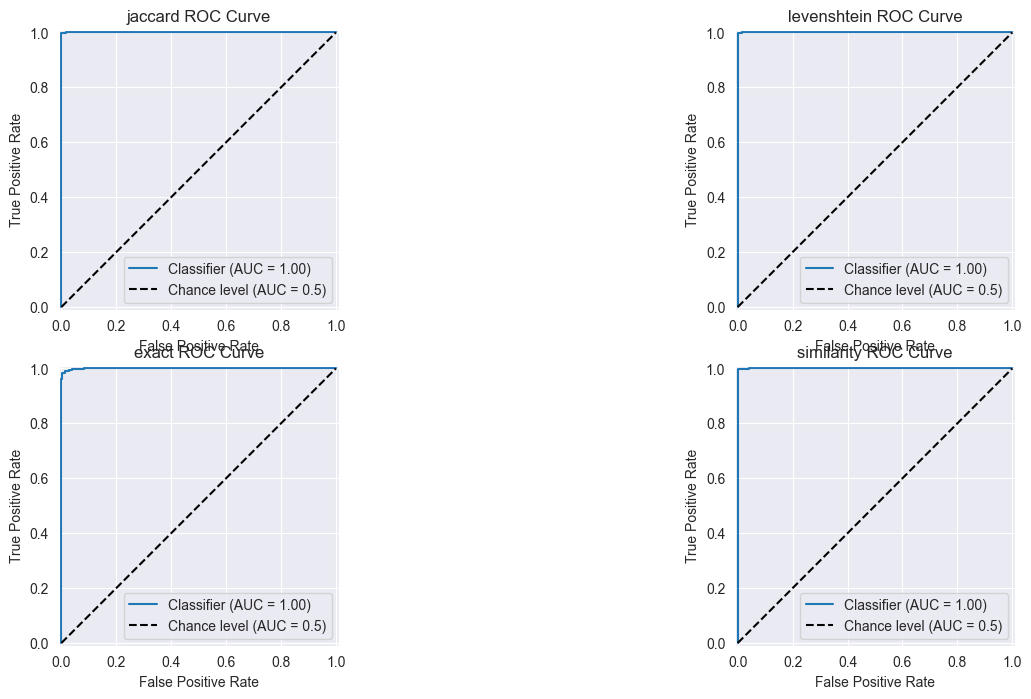

Metrics for SPIRIT datasets, on D:/Projets/Recherche/LogAD-LLM/data/eval/EVALCROSSED-STBSTAMP2


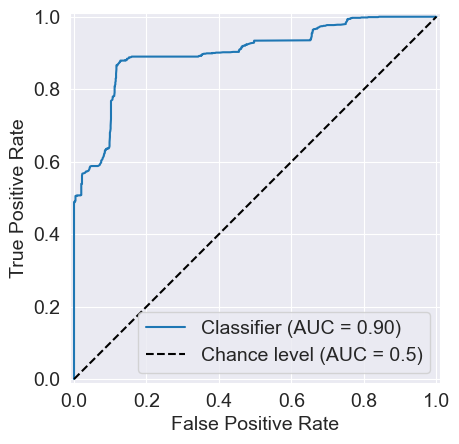

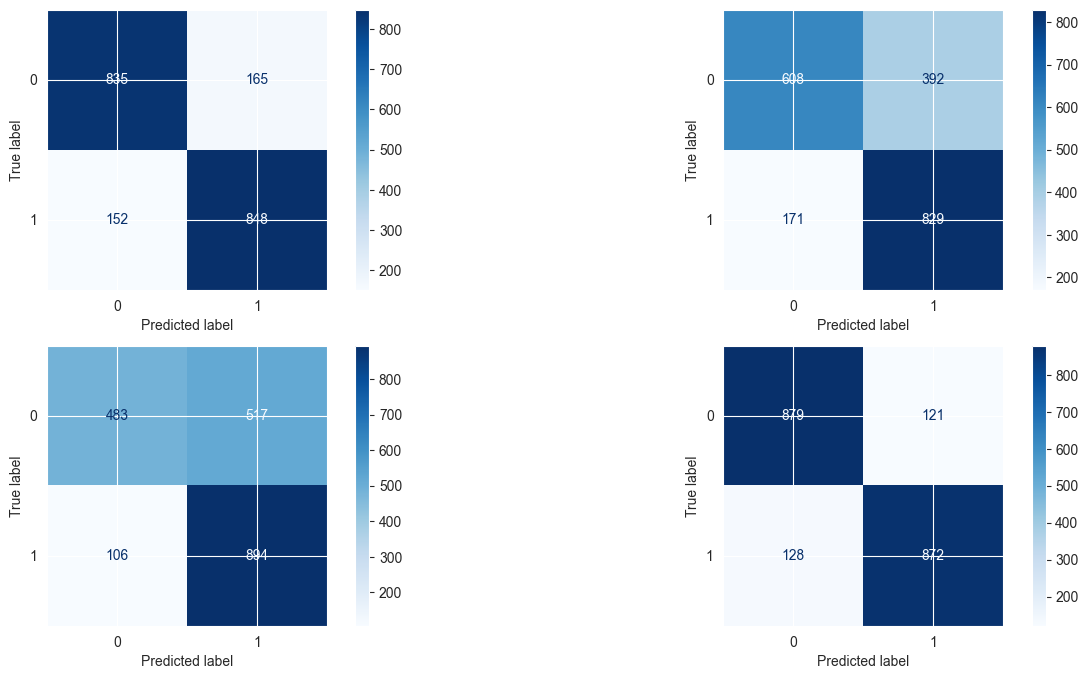

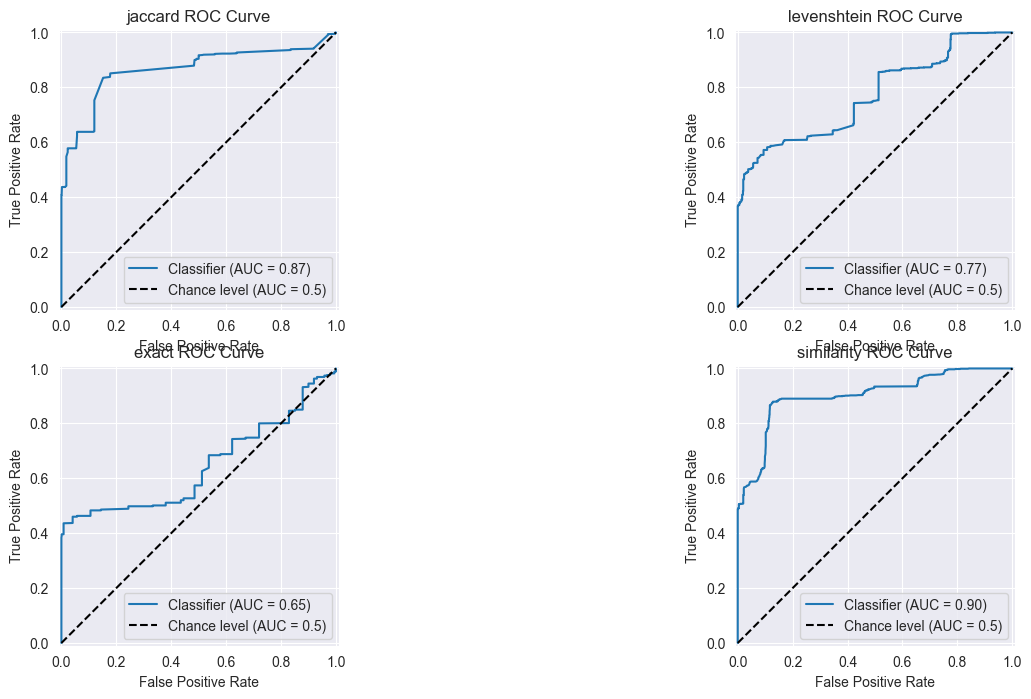

Metrics for THUNDERBIRD datasets, on D:/Projets/Recherche/LogAD-LLM/data/eval/EVALCROSSED-STBSTAMP2


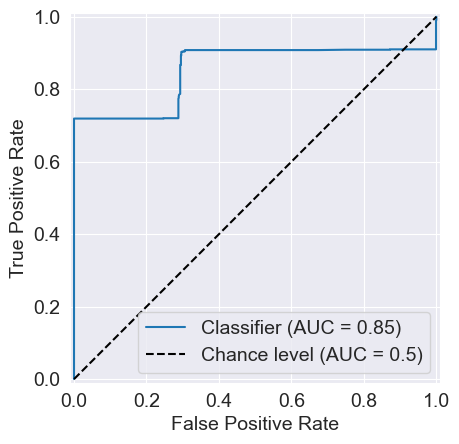

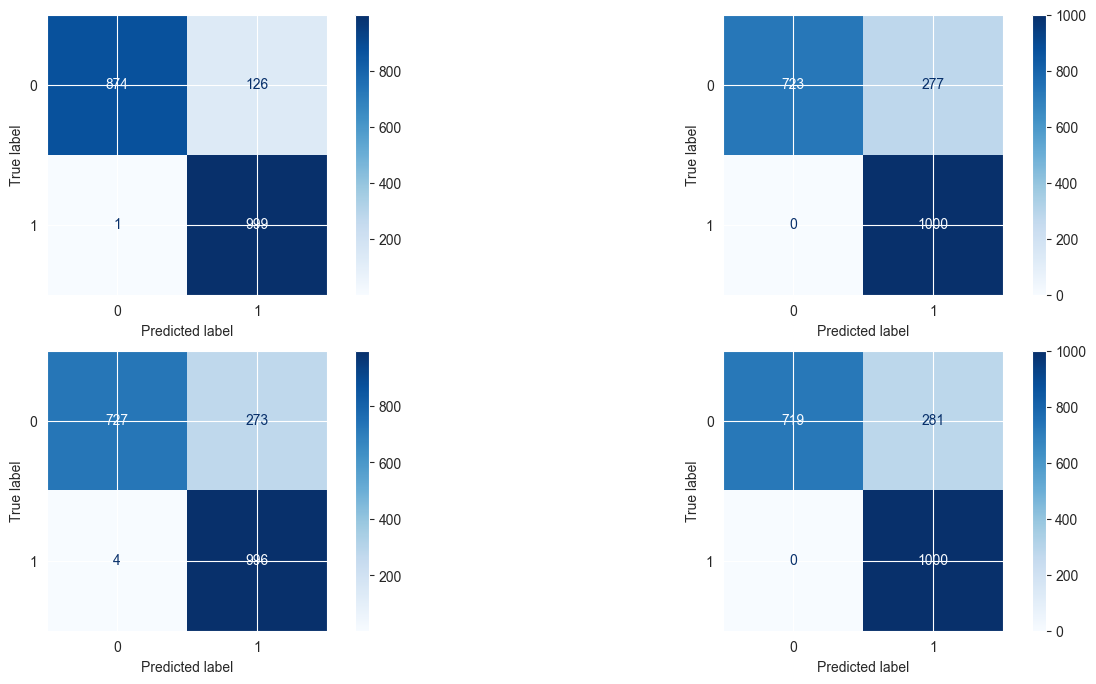

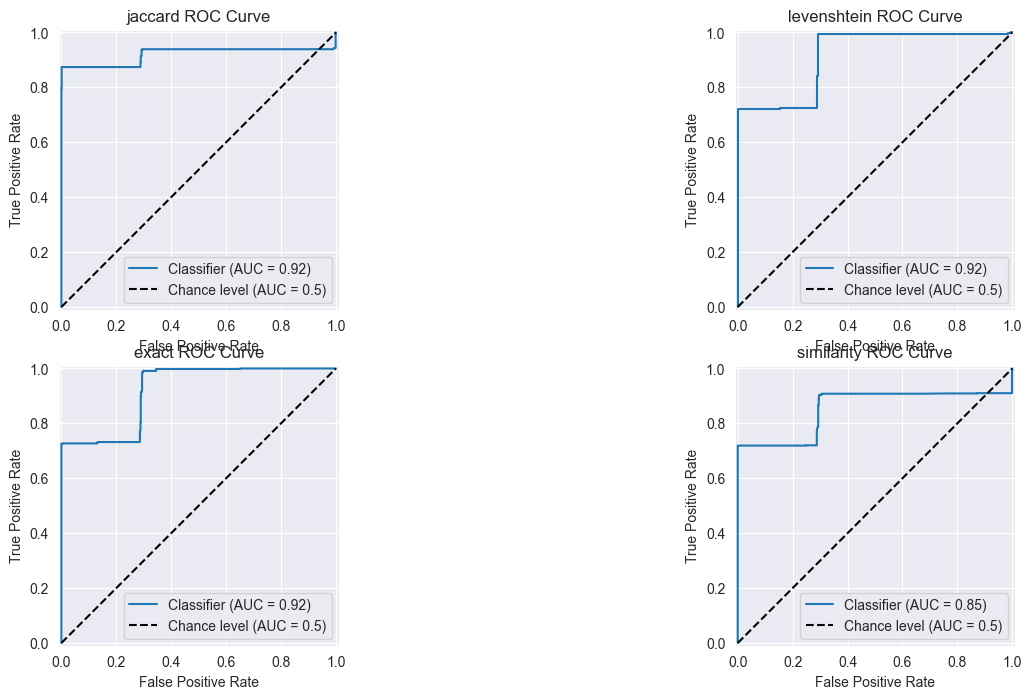

In [8]:
# threshold = what_metrics()
threshold=None
what_metrics()

dat = DATASETS

if isinstance(dat, list):
    if len(dat) < 1:
        dat = df['source'].unique()

    for DATASET in dat:
        what_metrics(DATASET, threshold)

elif isinstance(dat, str):
    what_metrics(dat, threshold)
# what_metrics("SPIRIT")